Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from random import choices, choice, randint, random
import lab9_lib
import numpy as np
from matplotlib import pyplot as plt

In [2]:
fitness = lab9_lib.make_problem(10)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

01000010011011110111111001010011101001101110001110: 31.36%
00001101100001011011001111011110101011100010101100: 23.33%
01100001110110010100011000010100000101011000110111: 9.13%
01111010000111100011010100110111100001010101100010: 9.13%
01100101000001111100110010010001001100111011001110: 7.33%
10011001101010000100010000111000011111001011000100: 9.34%
01000010000101111111011000001011111101011100110110: 9.33%
00110101010010111001111100010111110110011101110111: 9.11%
11110110000001110000001000011100001110111010111000: 7.33%
00000011101000010111100011000100101110110010000110: 7.33%
10


### Definition of the functions that will allow the exploration of new genomes to find the best path

In [3]:
def selection(population, fitnesses, fitness):
    """ This function is selecting individual from the population with probability their fitness ."""
    ind = choices(population, weights=fitnesses, k=1)[0]
    return ind

In [49]:
def selection2(population, fitnesses, fitness, k=2):
    """ This function is selecting  ."""
    ind = choices(population, k=k)
    best = ind[0]
    for i in ind:
        if fitness(i)> fitness(best):
            best = i
    return best

In [5]:
def xover(ind1, ind2):
    """ This function is performing crossover between two individuals."""
    gen_length = min(len(ind1), len(ind2))    
    g = randint(0, gen_length - 1)
    if randint(0, 1) == 0:
        return  ind1[:g] + ind2[g:]
    else:  
        return ind2[:g] + ind1[g:]
         

In [6]:
def double_xover(ind1, ind2):
    """ This function is performing two-point crossover on two individuals."""
    gen_length = min(len(ind1), len(ind2))
    g1 = randint(0, gen_length - 1)
    g2 = randint(g1, gen_length - 1)

    if randint(0, 1) == 0:
        return  ind1[:g1] + ind2[g1:g2] + ind1[g2:]
    else:   
        return  ind2[:g1] + ind1[g1:g2] + ind2[g2:]

In [7]:
def mutation(ind):
    """ This function is selecting one random gene and return a mutation of it."""
    gen_length = len(ind)
    new_ind = ind.copy()
    g = randint(0, gen_length-1)
    new_ind[g] = 1 - new_ind[g]
    return new_ind

In [8]:
def swap(ind):
    """ This function is selecting two random genes and return a swap of them."""
    gen_length = len(ind)
    new_ind = ind.copy()
    g1, g2 = tuple(choices(range(0, gen_length), k=2))
    new_ind[g1] = ind[g2]
    new_ind[g2] = ind[g1]
    return new_ind

In [9]:
def reversion(ind):
    """ This function is selecting two random genes and return a reversion of the genome between them."""
    gen_length = len(ind)
    new_ind = ind.copy()
    pos1 = randint(0, gen_length - 2)
    pos2 = randint(pos1, gen_length - 1)
    new_ind[pos1:pos2] = list(reversed(ind[pos1:pos2]))
    return new_ind

### Definition of the parameters


In [44]:
LEN_GEN = 1000
POP_SIZE = 60
MAX_GENERATIONS = 1000
MUTATION_RATE = 0.5
SWAP_RATE = 0.5
REVERSION_RATE = 0.5
CROSSOVER_RATE = 0.6
DOUBLE_CROSSOVER_RATE = 0.5
PROBLEM_SIZE = [1, 2, 5,10]
DESCENDANTS_SIZE = 30
NUM_GENERATIONS = 1000

I have tried various combinaisons of these parameters and those shown seems to be the best ones.

### Definition of the function of evolution

In [45]:
def evolution(population, fitness, early_stop = 10, select = 1):
    if select == 1:
        select = selection
    else:
        select = selection2
    stop = 0
    best_fit = float("-inf")
    list_fit = []
    fitnesses = [fitness(i) for i in population]
    for generation in range(NUM_GENERATIONS):
        descendants = []

        for _ in range(DESCENDANTS_SIZE):
            p1 = select(population, fitnesses, fitness)
            if random() < MUTATION_RATE:
                p1 = mutation(p1)
            elif random() < SWAP_RATE:
                p1 = swap(p1)
            elif random() < REVERSION_RATE:
                p1 = reversion(p1)
            else :
                p1 = p1

        
            if random() < CROSSOVER_RATE:
                p2 = select(population, fitnesses, fitness)
                d = xover(p1, p2)
            elif random() < DOUBLE_CROSSOVER_RATE:
                p2 = select(population, fitnesses, fitness)
                d = double_xover(p1, p2)
            else:
                d = p1

            descendants.append(d)


        new_population = population + descendants
        fitnesses = [fitness(i) for i in new_population]
        combined = list(zip(new_population, fitnesses))
        sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
        new_population = [elem[0] for elem in sorted_combined]
        population = new_population[:POP_SIZE]
        fitnesses = [elem[1] for elem in sorted_combined]   
        fitnesses = fitnesses[:POP_SIZE]
        best_indiv = population[0]

        if fitnesses[0] > best_fit:
            best_fit = fitnesses[0]
            stop = 0
            
        else:
            stop += 1

        list_fit.append(best_fit)

        if best_fit == 1:
            print(f"Best individual: {best_indiv}")
            print(f"Best fitness: 100%")
            print(f"Converged at generation {generation}")
            break   
        if stop >= early_stop:
            print(f"Converged at generation {generation}")
            print(f"Best individual: {best_indiv}")
            print(f"Best fitness: {fitnesses[0]:.2%}")
            break
        if generation == NUM_GENERATIONS - 1:
            print(f"Best individual: {best_indiv}")
            print(f"Best fitness: {fitnesses[0]:.2%}")
            print(f"Converged at generation {generation}")

    plt.plot(range(0, generation + 1), list_fit)
    plt.xlabel("Generations")
    plt.ylabel("Best fitness")
    plt.title("Evolution of the best fitness over generations")
    plt.show()



### Resolution

In [46]:
population = []
for n in range(POP_SIZE):
    ind = choices([0, 1], k=LEN_GEN)
    population.append(ind)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

fitness = lab9_lib.make_problem(2)


1011101101011110101011111000111010100001000010001101111011000111000010101010011001100111101010001101011100001111010111011001111111101010011010110100011011000010000100011100000000111000010100000000001100100101100101111001111011101110010110110001011011100110101111101111010111110000000111000011111111100010000101100110000010110001001110101101100001000101011001101100010111111110011100111100010000011111100101011011011011011011101000100001100101110001100000100001100000010010100000001110000110111000111101111011010100011010001101110101010101000100110111110011111001011101110001001111110110111110000011011110001110110010110101110100100000000111001011001001101011110000101100001101111010101111110110000010101111001101111101010100011101101010000111000110010010000100100000011111111000100010011110000010110011010101100010100111001011001010101000000011001010001110011011111010010010101000000011101100110111000001001101001110110110100010110000101100000100001001011110011001001110001010001010100101111011010101

Problem size: 1
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

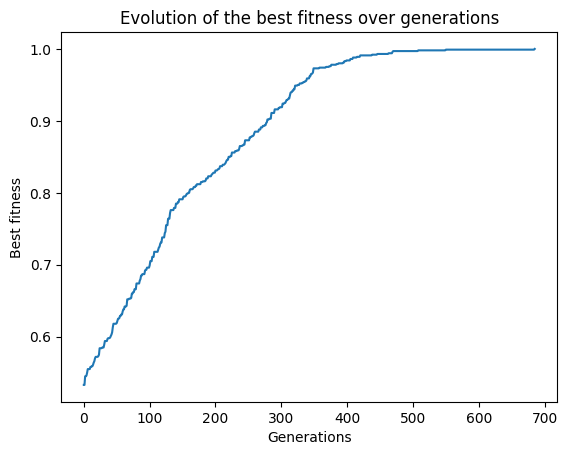

Number of fitness call :  61800
---------------------------------
Problem size: 2
Best individual: [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

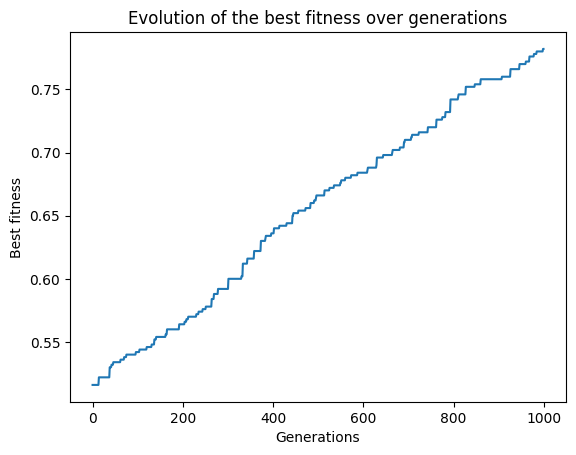

Number of fitness call :  90060
---------------------------------
Problem size: 5
Best individual: [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 

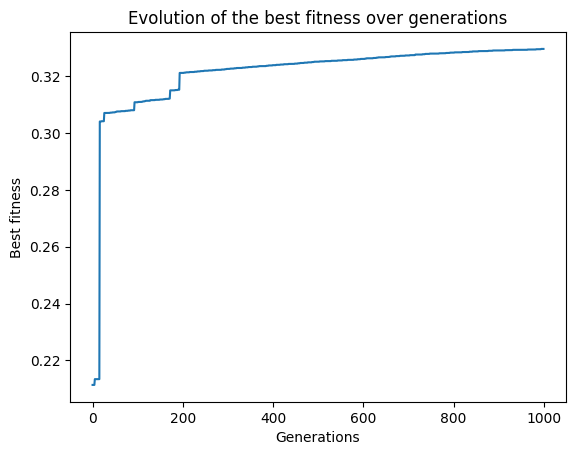

Number of fitness call :  90060
---------------------------------
Problem size: 10
Best individual: [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,

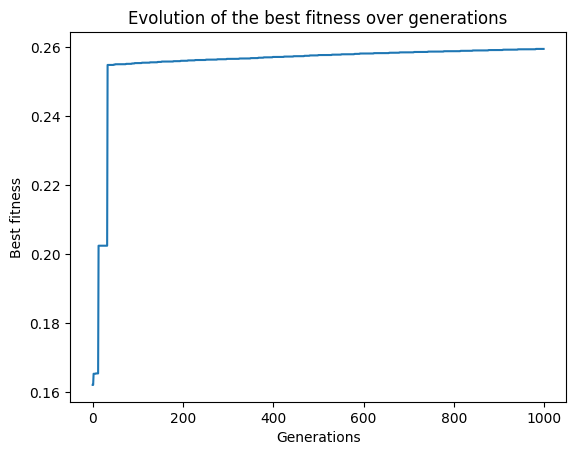

Number of fitness call :  90060
---------------------------------


In [47]:
for pb_size in PROBLEM_SIZE:
    print(f"Problem size: {pb_size}")
    fitness = lab9_lib.make_problem(pb_size)
    evolution(population, fitness, early_stop=200)
    print("Number of fitness call : ", fitness.calls)
    print("---------------------------------")

Putting a too small early stop is not a good idea with bigger problem size as it prevent from stopping at higher fitness values.
We can clearly see that with higher problem size the best individuals as a fitness wich is smaller.

Problem size: 1
Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

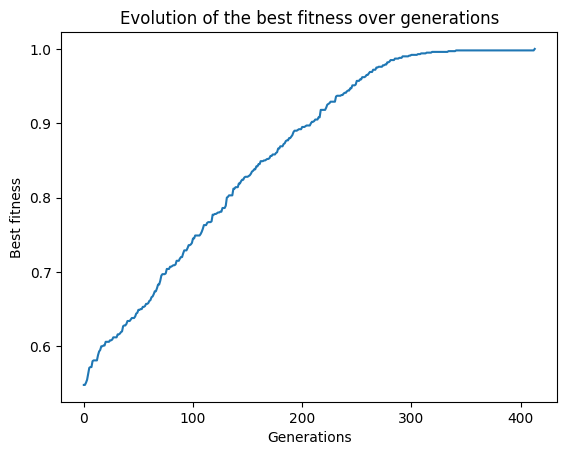

Number of fitness call :  126628
---------------------------------
Problem size: 2
Best individual: [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

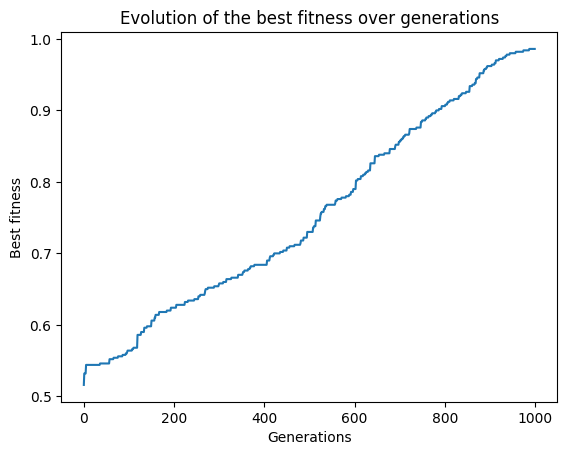

Number of fitness call :  306396
---------------------------------
Problem size: 5
Best individual: [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,

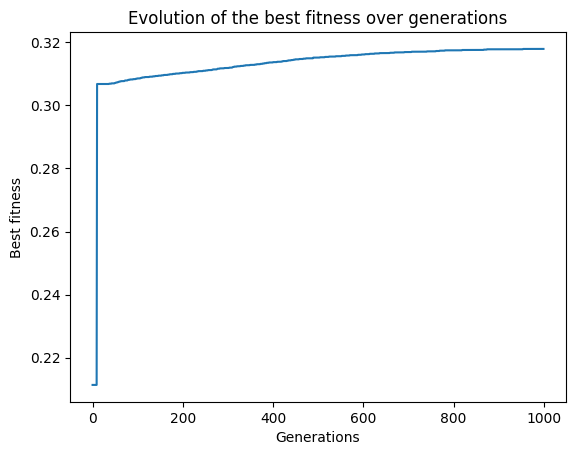

Number of fitness call :  306268
---------------------------------
Problem size: 10
Best individual: [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0

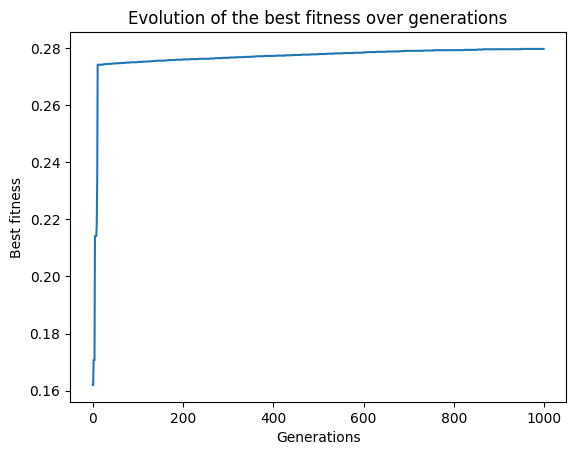

Number of fitness call :  306604
---------------------------------


In [50]:
for pb_size in PROBLEM_SIZE:
    print(f"Problem size: {pb_size}")
    fitness = lab9_lib.make_problem(pb_size)
    evolution(population, fitness, early_stop=200, select=2)
    print("Number of fitness call : ", fitness.calls)
    print("---------------------------------")

## Experimetations on parameters

Mutation rate: 0.1
WITH 1st SELECTION
Best individual: [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,

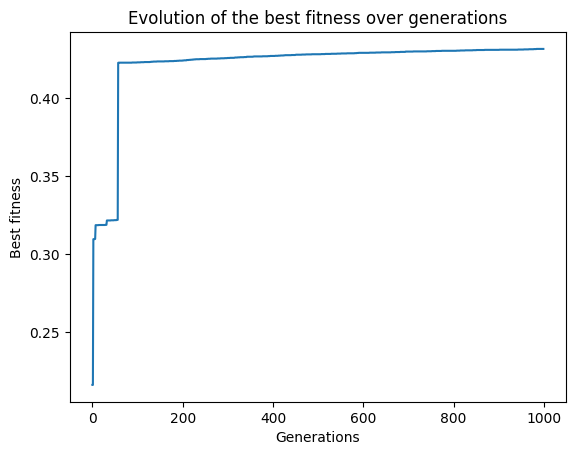

Number of fitness call :  90060
---------------------------------
WITH 2nd SELECTION
Best individual: [0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 

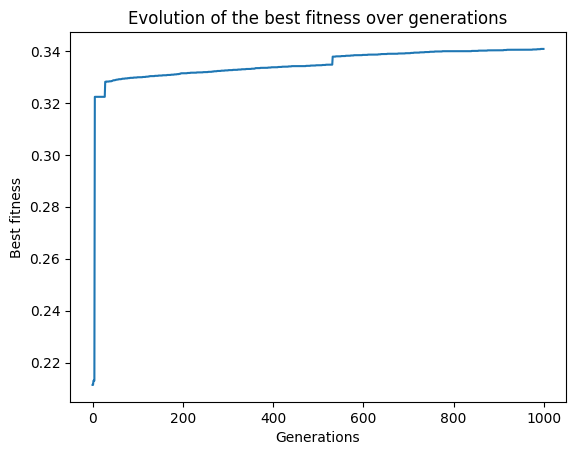

Number of fitness call :  306420
---------------------------------
Mutation rate: 0.3
WITH 1st SELECTION
Best individual: [0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0

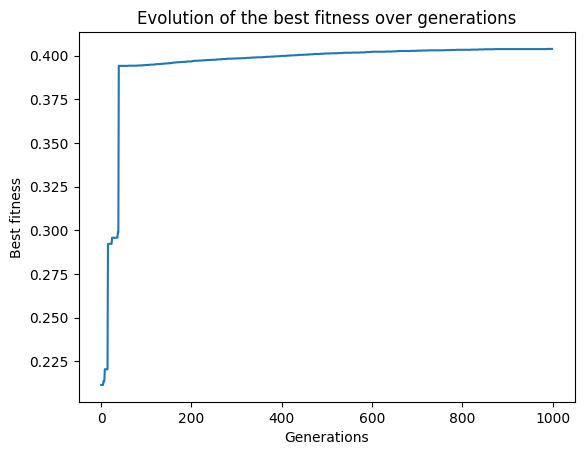

Number of fitness call :  90060
---------------------------------
WITH 2nd SELECTION
Best individual: [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 

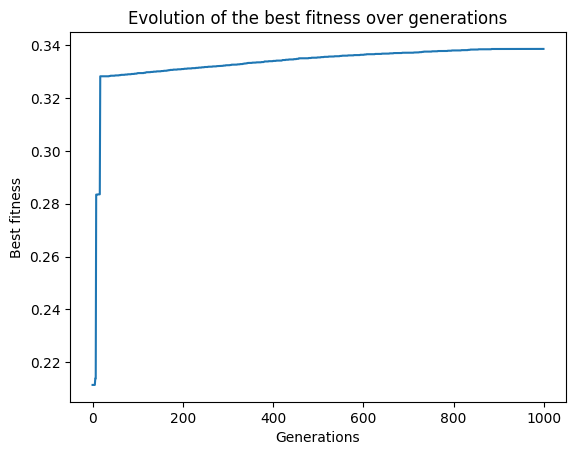

Number of fitness call :  305980
---------------------------------
Mutation rate: 0.5
WITH 1st SELECTION
Converged at generation 970
Best individual: [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 

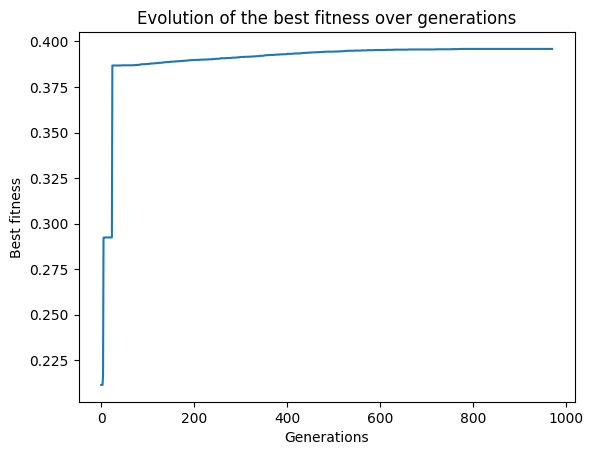

Number of fitness call :  87450
---------------------------------
WITH 2nd SELECTION
Converged at generation 992
Best individual: [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,

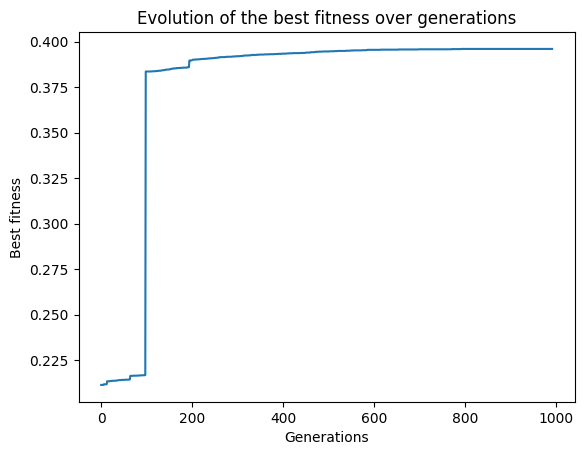

Number of fitness call :  303918
---------------------------------
Mutation rate: 0.7
WITH 1st SELECTION
Best individual: [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0

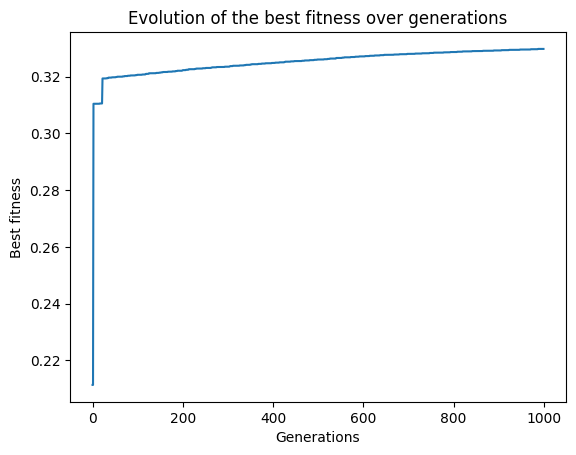

Number of fitness call :  90060
---------------------------------
WITH 2nd SELECTION
Best individual: [1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 

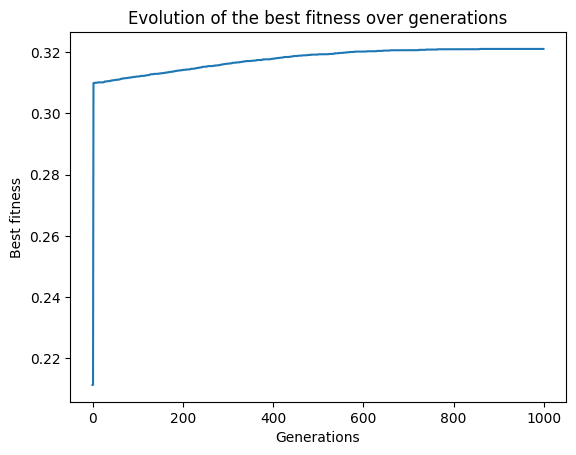

Number of fitness call :  305900
---------------------------------
Mutation rate: 0.9
WITH 1st SELECTION
Best individual: [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0

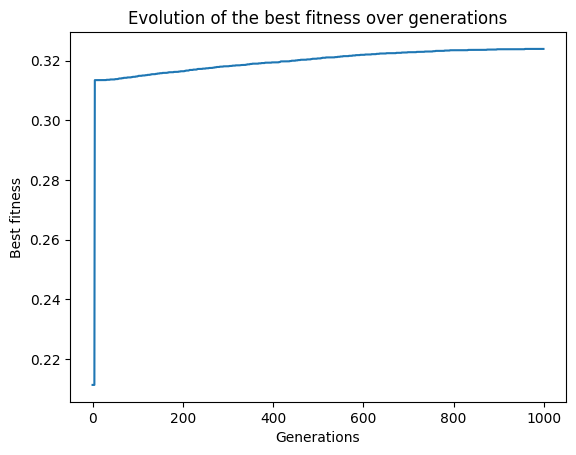

Number of fitness call :  90060
---------------------------------
WITH 2nd SELECTION
Converged at generation 755
Best individual: [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,

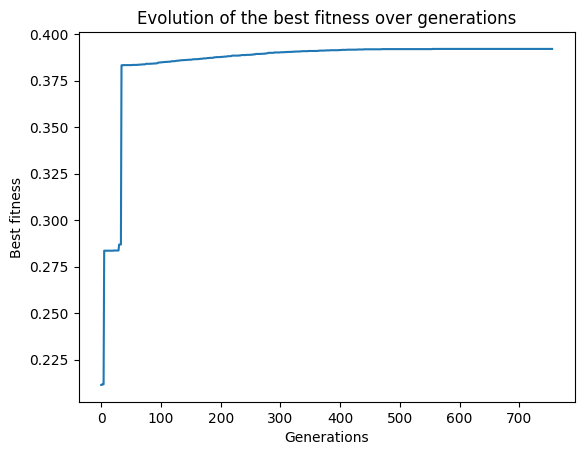

Number of fitness call :  231284
---------------------------------


In [51]:
for mutation_rate in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(f"Mutation rate: {mutation_rate}")
    MUTATION_RATE = mutation_rate
    print("WITH 1st SELECTION")
    fitness = lab9_lib.make_problem(5)
    evolution(population, fitness, early_stop=200)
    print("Number of fitness call : ", fitness.calls)
    print("---------------------------------")
    print("WITH 2nd SELECTION")
    fitness = lab9_lib.make_problem(5)
    evolution(population, fitness, early_stop=200,select=2)
    print("Number of fitness call : ", fitness.calls)
    print("---------------------------------")

A mutation rate of 0.5 seems to be the best. Of course to be sure I would need to check on different population, but it gives a good idea. We see that a mutation rate that is too small is not enough to obtain good results but a high one is not something that works well either.